<a href="https://colab.research.google.com/github/THANNAGA/Lagrangian/blob/main/GLV_bounded_lagrangian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Define a function to check if a token is a word
def is_word(token):
    return token.isalpha()

# Define a function to get the position of a letter/position token
def get_position(token):
    return int(token[1:]) if not is_word(token) else None

def contains_letter(token, letter):
    return letter in token


def create_matrix(tokens=[], WtoL=0.01, LtoW=0.05, LtoL=-0.1, WtoW=-0.5):
  # Initialize the adjacency matrix with all zeroes
  adjacency_matrix = np.zeros((len(tokens), len(tokens)))

  for i in range(len(tokens)):
      for j in range(len(tokens)):
          if i == j:
              continue  # a token is not connected to itself
          if is_word(tokens[i]) and is_word(tokens[j]):
              # Two word tokens are always connected with a -1
              adjacency_matrix[i, j] = WtoW
          elif not is_word(tokens[i]) and not is_word(tokens[j]) and get_position(tokens[i]) == get_position(tokens[j]):
              # Two letter/position tokens are connected with a -1 if they have the same position
              adjacency_matrix[i, j] = LtoL

  # Iterate over the tokens again to add +1 connections
  for i in range(len(tokens)):
      for j in range(len(tokens)):
          if is_word(tokens[i]) and not is_word(tokens[j]) and contains_letter(tokens[i], tokens[j][0]):
              # If a word token contains a letter/position token, there is a positive LtoWExc connection between them
              adjacency_matrix[i, j] = WtoL
              adjacency_matrix[j, i] = LtoW
  return adjacency_matrix

In [ ]:
from re import I
import numpy as np
import matplotlib.pyplot as plt


def stabilize_matrix(A, show=True):

  n,n = A.shape
  print ('A', A)
  # subtract (real of top_eigenvalue + eps) to diagonal
  eigenvalues = np.linalg.eigvals(A); print ('eigenvalues', eigenvalues)
  top_real = np.max(np.real(eigenvalues))

  A = A - (2*top_real)*np.eye(n)

  # Verify that the row sums are negative
  row_sums = A.sum(axis=1)
  row_sums_negative = np.all(row_sums < 0)

  # Verify that the real parts of the eigenvalues of A are negative
  eigenvalues = np.linalg.eigvals(A)
  real_parts_negative = np.all(np.real(eigenvalues) < 0)

  print ('A', A)
  print ('row_sums', row_sums)
  print ('row_sums_negative', row_sums_negative)
  print ('eigenvalues', eigenvalues)
  print ('real_parts_negative', real_parts_negative)

  if show:
    plt.figure(figsize=(8, 6))
    plt.imshow(A, cmap='coolwarm', interpolation='none')
    plt.colorbar(label='Connection value')

    # Move the x-axis ticks to the top of the plot
    plt.tick_params(bottom=False, top=True, labelbottom=False, labeltop=True)

    plt.xticks(np.arange(len(tokens)), tokens)
    plt.yticks(np.arange(len(tokens)), tokens)
    plt.title('Adjacency Matrix')
    plt.show()
  return A

A [[0.   0.   0.05]
 [0.   0.   0.05]
 [0.01 0.01 0.  ]]
eigenvalues [-3.16227766e-02  3.40507245e-19  3.16227766e-02]
A [[-0.06324555  0.          0.05      ]
 [ 0.         -0.06324555  0.05      ]
 [ 0.01        0.01       -0.06324555]]
row_sums [-0.01324555 -0.01324555 -0.04324555]
row_sums_negative True
eigenvalues [-0.09486833 -0.06324555 -0.03162278]
real_parts_negative True


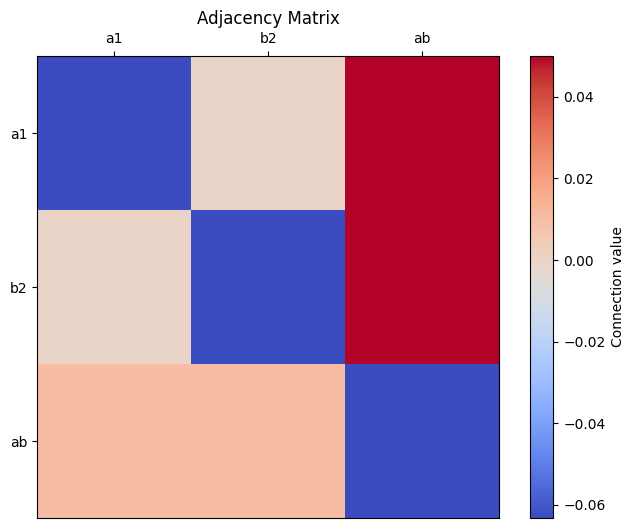

In [ ]:
#tokens = ['a1', 'b2', 'c1', 'd2', 'a1b2', 'c1d2', 'a1d2']
tokens = ['a1', 'b2', 'ab']
A = create_matrix(tokens = tokens)
A = stabilize_matrix(A)

r [0.5 0.5 0.5 0.5 0.5 0.5 0.5]
A [[ 0.    0.   -0.1   0.    0.05  0.    0.05]
 [ 0.    0.    0.   -0.1   0.05  0.    0.  ]
 [-0.1   0.    0.    0.    0.    0.05  0.  ]
 [ 0.   -0.1   0.    0.    0.    0.05  0.05]
 [ 0.01  0.01  0.    0.    0.   -0.5  -0.5 ]
 [ 0.    0.    0.01  0.01 -0.5   0.   -0.5 ]
 [ 0.01  0.    0.    0.01 -0.5  -0.5   0.  ]]
eigenvalues [-1.00181461 -0.1        -0.09833796  0.09751543  0.09932073  0.50248457
  0.50083183]
A [[-1.00496913  0.         -0.1         0.          0.05        0.
   0.05      ]
 [ 0.         -1.00496913  0.         -0.1         0.05        0.
   0.        ]
 [-0.1         0.         -1.00496913  0.          0.          0.05
   0.        ]
 [ 0.         -0.1         0.         -1.00496913  0.          0.05
   0.05      ]
 [ 0.01        0.01        0.          0.         -1.00496913 -0.5
  -0.5       ]
 [ 0.          0.          0.01        0.01       -0.5        -1.00496913
  -0.5       ]
 [ 0.01        0.          0.          0.01       

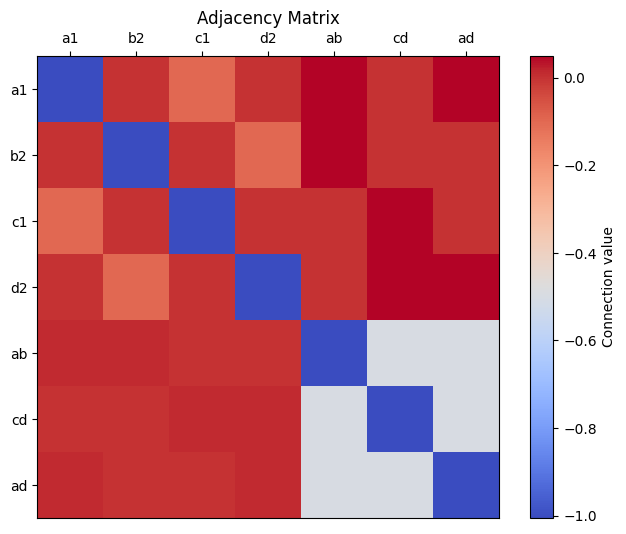

X.shape (1000, 7)


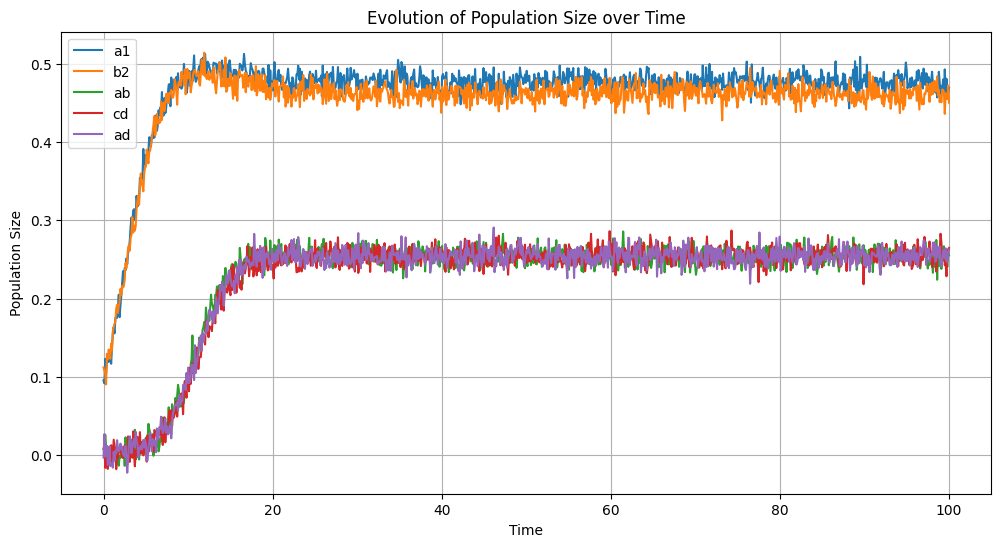

In [ ]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Tokens
tokens = ['a1', 'b2', 'c1', 'd2', 'ab', 'cd', 'ad']

# Number of species
N = len(tokens)

# Let's set intrinsic growth rates such that r_i > 0
r = 0.5*np.ones(N)
print ('r', r)

A = create_matrix(tokens = tokens)
A = stabilize_matrix(A)

# Define the system of differential equations
def dXdt(X, t):
    return X * (r + np.dot(A, X))

# Initial conditions: start with equal populations
#X0 = 0.01*np.ones(N)
X0 = [0.1, 0.1, 0.001, 0.001, 0.001, 0.001, 0.001]

# Time points
T = 100
t = np.linspace(0, T, 1000)

# Solve the system of differential equations
X = odeint(dXdt, X0, t)

# Plot the results
plt.figure(figsize=(12, 6)); print ('X.shape', X.shape)

select = ['a1', 'b2', 'ab', 'cd', 'ad']
tokens = ['a1', 'b2', 'c1', 'd2', 'ab', 'cd', 'ad']
for i in range(X.shape[1]):
    if tokens[i] in select:
      plt.plot(t, X[:, i] +0.01*np.random.randn(X.shape[0]), label=tokens[i])
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Evolution of Population Size over Time')
plt.grid(True)
plt.show()
